<a href="https://colab.research.google.com/github/shivansh2310/Finance-Stuff/blob/main/Bond_Valuation_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pytest-playwright

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.4/37.4 MB 35.5 MB/s eta 0:00:00


In [4]:
!playwright install

152.8 MiB [] 0% 0.0s152.8 MiB [] 0% 29.5s152.8 MiB [] 0% 16.6s152.8 MiB [] 0% 11.0s152.8 MiB [] 0% 7.6s152.8 MiB [] 1% 5.6s152.8 MiB [] 1% 5.3s152.8 MiB [] 2% 4.7s152.8 MiB [] 2% 4.9s152.8 MiB [] 3% 4.9s152.8 MiB [] 3% 5.0s152.8 MiB [] 3% 4.8s152.8 MiB [] 4% 4.5s152.8 MiB [] 4% 4.7s152.8 MiB [] 4% 4.8s152.8 MiB [] 5% 4.8s152.8 MiB [] 5% 4.5s152.8 MiB [] 6% 4.5s152.8 MiB [] 7% 4.3s152.8 MiB [] 8% 4.1s152.8 MiB [] 8% 4.2s152.8 MiB [] 9% 4.1s152.8 MiB [] 9% 4.0s152.8 MiB [] 10% 3.9s152.8 MiB [] 11% 3.8s152.8 MiB [] 11% 3.7s152.8 MiB [] 12% 3.6s152.8 MiB [] 12% 3.5s152.8 MiB [] 13% 3.5s152.8 MiB [] 14% 3.4s152.8 MiB [] 15% 3.4s152.8 MiB [] 16% 3.3s152.8 MiB [] 17% 3.3s152.8 MiB [] 18% 3.1s152.8 MiB [] 19% 3.0s152.8 MiB [] 20% 2.9s152.8 MiB [] 21% 2.9s152.8 MiB [] 21% 2.8s152.8 MiB [] 23% 2.7s152.8 MiB [] 24% 2.6s152.8 MiB [] 24% 2.5s152.8 MiB [] 25% 2.5s152.8 MiB [] 26% 2.4s152.8 MiB [] 27% 2.3s152.8 MiB [] 28% 2.3s152.8 MiB [] 29% 2.3s152.8 MiB [] 30% 2.2s152.8 MiB [] 31% 2.1s152.8 MiB []

In [141]:
# Python libraries to install
from datetime import date
from datetime import datetime as dt

import numpy as np
import pandas as pd

# The use of the async_api is mandatory since we will be running the Playwright code from inside a Jupyter Notebook cell.
from playwright.async_api import async_playwright

In [142]:
# Input of issuer name (corporations that are subsidiaries of HESS CORP and contain the name 'hess' will be included as well)
issuer_name = "Colgate"

# Maturity dates
date_start = "2028-01-01"
date_end = "2050-01-01"

In [143]:
scrape_new_data = True


async def scrape_bond_data(issuer_name, date_start, date_end):
    async with async_playwright() as pw:
        browser = await pw.chromium.launch(headless=True)
        context = await browser.new_context(viewport={"width": 1920, "height": 1080})
        page = await context.new_page()

        # Navigate to the page
        await page.goto("https://www.finra.org/finra-data/fixed-income/corp-and-agency")

        # Fill in the search criteria
        await page.locator('input[placeholder="Issuer Name"]').fill(issuer_name)
        await page.locator("input#form-name").nth(0).fill(date_start)
        await page.locator("input#form-name").nth(1).fill(date_end)

        # Submit the search form
        await page.locator('text="Show Results"').click()
        await page.wait_for_timeout(5000)  # Adjust the timeout as necessary

        # Extend the container for the data grid to ensure all data is visible
        await page.locator("ag-grid-angular").evaluate(
            """
            element => {
                element.style.height = "1500px";
                element.style.width = "4500px";
            }
        """
        )
        await page.wait_for_timeout(2000)  # Adjust the timeout as necessary

        # Extract the data
        column_ids = [
            "issueSymbolIdentifier",
            "issuerName",
            "isCallable",
            "productSubTypeCode",
            "couponRate",
            "maturityDate",
            "industryGroup",
            "moodysRating",
            "standardAndPoorsRating",
            "lastSalePrice",
            "lastSaleYield",
        ]

        data = {}
        for column_id in column_ids:
            column_data = await page.locator(
                f"div[col-id='{column_id}']"
            ).all_text_contents()
            data[column_id] = column_data[1:]  # Skip the header

        # Close the browser
        await browser.close()

        # Convert to a pandas DataFrame
        return pd.DataFrame.from_dict(data)


# Run the function
if scrape_new_data:
    bond_prices_df = await scrape_bond_data(  # noQA F704
        issuer_name, date_start, date_end
    )
else:
    bond_prices_df = pd.read_csv("bond-prices.csv")

In [144]:
bond_prices_df.head(10)

,issueSymbolIdentifier,issuerName,isCallable,productSubTypeCode,couponRate,maturityDate,industryGroup,moodysRating,standardAndPoorsRating,lastSalePrice,lastSaleYield
0,CG5205040,COLGATE ENERGY PARTNERS III LLC,Y,CORP,5.875,2029-07-01,,,BB-,97.5,
1,CG5205039,COLGATE ENERGY PARTNERS III LLC,Y,CORP,5.875,2029-07-01,OTHF,B1,BB-,97.75,6.369711
2,CL5455601,COLGATE PALMOLIVE CO,Y,CORP,3.25,2032-08-15,CONS,Aa3,AA-,91.362,4.47507
3,CL5548811,COLGATE PALMOLIVE CO,Y,CORP,4.6,2033-03-01,CONS,Aa3,AA-,101.113,4.446699
4,CL5548671,COLGATE PALMOLIVE CO,Y,CORP,4.6,2028-03-01,CONS,Aa3,AA-,101.614,4.160016
5,COLG3967077,COLGATE UNIV,N,CORP,4.106,2043-07-01,OTHS,,AA,,
6,CL.HK,COLGATE-PALMOLIVE CO MEDIUM TERM NTS BOOK ENTRY,Y,CORP,5.28894,2045-04-04,CONS,Aa3,AA-,99.625,999999.99
7,CL4522366,COLGATE-PALMOLIVE CO MEDIUM TERM NTS BOOK ENTRY,Y,CORP,3.7,2047-08-01,CONS,Aa3,AA-,84.62,4.79
8,CL4275867,COLGATE-PALMOLIVE CO MEDIUM TERM NTS BOOK ENTRY,N,CORP,4,2045-08-15,CONS,Aa3,AA-,88.648,4.845057
9,CL.HN,COLGATE-PALMOLIVE CO MEDIUM TERM NTS BOOK ENTRY,Y,CORP,5.33099,2046-12-04,CONS,,AA-,100,


In [145]:
bond_prices_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   issueSymbolIdentifier   16 non-null     object
 1   issuerName              16 non-null     object
 2   isCallable              16 non-null     object
 3   productSubTypeCode      16 non-null     object
 4   couponRate              16 non-null     object
 5   maturityDate            16 non-null     object
 6   industryGroup           16 non-null     object
 7   moodysRating            16 non-null     object
 8   standardAndPoorsRating  16 non-null     object
 9   lastSalePrice           16 non-null     object
 10  lastSaleYield           16 non-null     object
dtypes: object(11)
memory usage: 1.5+ KB


In [146]:
# We expect that the columns: "couponRate", "lastSalePrice" and "lastSaleYield" are floats.
bond_prices_df["couponRate"] = pd.to_numeric(bond_prices_df["couponRate"])
bond_prices_df["lastSalePrice"] = pd.to_numeric(bond_prices_df["lastSalePrice"])
bond_prices_df["lastSaleYield"] = pd.to_numeric(bond_prices_df["lastSaleYield"])

# The column "maturityDate" can also be converted to "Timestamp" or "Datetime" object.
bond_prices_df["maturityDate"] = pd.to_datetime(
    bond_prices_df["maturityDate"], infer_datetime_format=True
)

In [147]:
bond_prices_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   issueSymbolIdentifier   16 non-null     object        
 1   issuerName              16 non-null     object        
 2   isCallable              16 non-null     object        
 3   productSubTypeCode      16 non-null     object        
 4   couponRate              16 non-null     float64       
 5   maturityDate            16 non-null     datetime64[ns]
 6   industryGroup           16 non-null     object        
 7   moodysRating            16 non-null     object        
 8   standardAndPoorsRating  16 non-null     object        
 9   lastSalePrice           15 non-null     float64       
 10  lastSaleYield           8 non-null      float64       
dtypes: datetime64[ns](1), float64(3), object(7)
memory usage: 1.5+ KB


In [148]:
bond_prices_df

,issueSymbolIdentifier,issuerName,isCallable,productSubTypeCode,couponRate,maturityDate,industryGroup,moodysRating,standardAndPoorsRating,lastSalePrice,lastSaleYield
0,CG5205040,COLGATE ENERGY PARTNERS III LLC,Y,CORP,5.87500,2029-07-01,,,BB-,97.500,NaN
1,CG5205039,COLGATE ENERGY PARTNERS III LLC,Y,CORP,5.87500,2029-07-01,OTHF,B1,BB-,97.750,6.369711
2,CL5455601,COLGATE PALMOLIVE CO,Y,CORP,3.25000,2032-08-15,CONS,Aa3,AA-,91.362,4.475070
3,CL5548811,COLGATE PALMOLIVE CO,Y,CORP,4.60000,2033-03-01,CONS,Aa3,AA-,101.113,4.446699
4,CL5548671,COLGATE PALMOLIVE CO,Y,CORP,4.60000,2028-03-01,CONS,Aa3,AA-,101.614,4.160016
5,COLG3967077,COLGATE UNIV,N,CORP,4.10600,2043-07-01,OTHS,,AA,NaN,NaN
6,CL.HK,COLGATE-PALMOLIVE CO MEDIUM TERM NTS BOOK ENTRY,Y,CORP,5.28894,2045-04-04,CONS,Aa3,AA-,99.625,999999.990000
7,CL4522366,COLGATE-PALMOLIVE CO MEDIUM TERM NTS BOOK ENTRY,Y,CORP,3.70000,2047-08-01,CONS,Aa3,AA-,84.620,4.790000
8,CL4275867,COLGATE-PALMOLIVE CO MEDIUM TERM NTS BOOK ENTRY,N,CORP,4.00000,2045-08-15,CONS,Aa3,AA-,88.648,4.845057
9,CL.HN,COLGATE-PALMOLIVE CO MEDIUM TERM NTS BOOK ENTRY,Y,CORP,5.33099,2046-12-04,CONS,,AA-,100.000,NaN


In [149]:
bond_prices_df = bond_prices_df.drop(['industryGroup'], axis=1)

In [150]:
bond_prices_df = bond_prices_df.rename(columns={'issueSymbolIdentifier': 'Symbol' ,
                                                'issuerName': 'Issuer', 'isCallable': 'Callable',
                                                'productSubTypeCode': 'Sub-type code', 'couponRate': 'Coupon',
                                                'maturityDate': 'Maturity', 'moodysRating': 'Moody\'s®',
                                                'standardAndPoorsRating': 'S&P', 'lastSalePrice': 'Price', 'lastSaleYield': 'Yield'})

In [151]:
bond_prices_df

,Symbol,Issuer,Callable,Sub-type code,Coupon,Maturity,Moody's®,S&P,Price,Yield
0,CG5205040,COLGATE ENERGY PARTNERS III LLC,Y,CORP,5.87500,2029-07-01,,BB-,97.500,NaN
1,CG5205039,COLGATE ENERGY PARTNERS III LLC,Y,CORP,5.87500,2029-07-01,B1,BB-,97.750,6.369711
2,CL5455601,COLGATE PALMOLIVE CO,Y,CORP,3.25000,2032-08-15,Aa3,AA-,91.362,4.475070
3,CL5548811,COLGATE PALMOLIVE CO,Y,CORP,4.60000,2033-03-01,Aa3,AA-,101.113,4.446699
4,CL5548671,COLGATE PALMOLIVE CO,Y,CORP,4.60000,2028-03-01,Aa3,AA-,101.614,4.160016
5,COLG3967077,COLGATE UNIV,N,CORP,4.10600,2043-07-01,,AA,NaN,NaN
6,CL.HK,COLGATE-PALMOLIVE CO MEDIUM TERM NTS BOOK ENTRY,Y,CORP,5.28894,2045-04-04,Aa3,AA-,99.625,999999.990000
7,CL4522366,COLGATE-PALMOLIVE CO MEDIUM TERM NTS BOOK ENTRY,Y,CORP,3.70000,2047-08-01,Aa3,AA-,84.620,4.790000
8,CL4275867,COLGATE-PALMOLIVE CO MEDIUM TERM NTS BOOK ENTRY,N,CORP,4.00000,2045-08-15,Aa3,AA-,88.648,4.845057
9,CL.HN,COLGATE-PALMOLIVE CO MEDIUM TERM NTS BOOK ENTRY,Y,CORP,5.33099,2046-12-04,,AA-,100.000,NaN


In [152]:
bond_prices_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Symbol         16 non-null     object        
 1   Issuer         16 non-null     object        
 2   Callable       16 non-null     object        
 3   Sub-type code  16 non-null     object        
 4   Coupon         16 non-null     float64       
 5   Maturity       16 non-null     datetime64[ns]
 6   Moody's®       16 non-null     object        
 7   S&P            16 non-null     object        
 8   Price          15 non-null     float64       
 9   Yield          8 non-null      float64       
dtypes: datetime64[ns](1), float64(3), object(6)
memory usage: 1.4+ KB


In [153]:
def bond_dataframe_filter(bond_prices_df):
    # Drop bonds with missing yields and missing credit ratings
    bond_prices_df["Yield"].replace("", np.nan, inplace=True)
    bond_prices_df["Moody's®"].replace({"WR": np.nan, "": np.nan}, inplace=True)
    bond_prices_df["S&P"].replace({"NR": np.nan, "": np.nan}, inplace=True)
    bond_prices_df = bond_prices_df.dropna(subset=["Yield"])
    bond_prices_df = bond_prices_df.dropna(subset=["Moody's®"])
    bond_prices_df = bond_prices_df.dropna(subset=["S&P"])

    # Create Maturity Years column that aligns with Semi-Annual Payments from corporate bonds
    bond_prices_df["Yield"] = bond_prices_df["Yield"].astype(float)
    bond_prices_df["Coupon"] = bond_prices_df["Coupon"].astype(float)
    bond_prices_df["Price"] = bond_prices_df["Price"].astype(float)

    now = dt.strptime(date.today().strftime("%m/%d/%Y"), "%m/%d/%Y")
    bond_prices_df["Maturity"] = pd.to_datetime(bond_prices_df["Maturity"]).dt.strftime("%m/%d/%Y")
    daystillmaturity = []
    yearstillmaturity = []
    for maturity in bond_prices_df["Maturity"]:
        daystillmaturity.append((dt.strptime(maturity, "%m/%d/%Y") - now).days)
        yearstillmaturity.append((dt.strptime(maturity, "%m/%d/%Y") - now).days / 360)
    bond_prices_df = bond_prices_df.reset_index(drop=True)
    bond_prices_df["Maturity"] = pd.Series(daystillmaturity)
    #         `df['Maturity Years'] = pd.Series(yearstillmaturity).round()` # Better for Annual Payments
    bond_prices_df["Maturity Years"] = (
        round(pd.Series(yearstillmaturity) / 0.5) * 0.5
    )  # Better for Semi-Annual Payments

    # Target bonds with short-term maturities
    bond_prices_df["Maturity"] = bond_prices_df["Maturity"].astype(float)
    # `df = df.loc[df['Maturity'] >= 0]`
    years_mask = (bond_prices_df["Maturity Years"] > 0) & (bond_prices_df["Maturity Years"] <= 5)
    bond_prices_df = bond_prices_df.loc[years_mask]
    return bond_prices_df

In [154]:
bond_df_result = bond_dataframe_filter(bond_prices_df)
bond_df_result

,Symbol,Issuer,Callable,Sub-type code,Coupon,Maturity,Moody's®,S&P,Price,Yield,Maturity Years
3,CL5548671,COLGATE PALMOLIVE CO,Y,CORP,4.60,1503.0,Aa3,AA-,101.614,4.160016,4.0
7,CL.GO,COLGATE-PALMOLIVE CO MEDIUM TERM NTS BOOK ENTRY,N,CORP,6.45,1610.0,Aa3,AA-,108.342,4.390000,4.5


In [155]:
import numpy as np
import pandas as pd
import yfinance as yfin

yfin.pdr_override()

from datetime import date
from datetime import datetime as dt
from datetime import timedelta

In [156]:
# Ten-Year Risk-free Rate
timespan = 100
current_date = date.today()
past_date = current_date - timedelta(days=timespan)
ten_year_risk_free_rate_df = yfin.download("^TNX", past_date, current_date)
ten_year_risk_free_rate = (
    ten_year_risk_free_rate_df.iloc[len(ten_year_risk_free_rate_df) - 1, 4]
) / 100
ten_year_risk_free_rate

[*********************100%%**********************]  1 of 1 completed


0.041440000534057615

In [157]:
# Market Risk Premium
market_risk_premium = 0.0472

In [158]:
# Market Equity Beta
stock_market_beta = 1

In [159]:
# Market Rate of Return
market_rate_of_return = ten_year_risk_free_rate + (
    stock_market_beta * market_risk_premium
)
market_rate_of_return

0.08864000053405761

In [160]:
# Vanguard Short-Term Corporate Bond Index Fund ETF Shares
bond_fund_ticker = "VCSH"

In [161]:
# Download data for the bond fund and the market
market_data = yfin.download("SPY", past_date, current_date)  # the market
fund_data = yfin.download("VCSH", past_date, current_date)  # the bond fund

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [162]:
# Approach #1 - Covariance/Variance Method:

# Calculate the covariance between the fund and the market -- this is the numerator in the Beta calculation
fund_market_cov = (
    fund_data["Adj Close"].pct_change().cov(market_data["Adj Close"].pct_change())
)
print("covariance between fund and market: ", fund_market_cov)

# Calculate market (S&P) variance -- this is the denominator in the Beta calculation
market_var = market_data["Adj Close"].pct_change().var()
print("market variance: ", market_var)

# Calculate Beta
bond_fund_beta_cv = fund_market_cov / market_var
print("bond fund beta (using covariance/variance): ", bond_fund_beta_cv)

covariance between fund and market:  5.5827802929911135e-06
market variance:  5.571062638198689e-05
bond fund beta (using covariance/variance):  0.10021033069547776


In [163]:
# Approach #2 - Correlation Method:

# Calculate the standard deviation of the market by taking the square root of the variance, for use in the denominator
market_stdev = market_var**0.5
print("market standard deviation: ", market_stdev)

# Calculate bond fund standard deviation, for use in the numerator
fund_stdev = fund_data["Adj Close"].pct_change().std()
print("fund standard deviation: ", fund_stdev)

# Calculate Pearson correlation between bond fund and market (S&P), for use in the numerator
fund_market_Pearson_corr = (
    fund_data["Adj Close"]
    .pct_change()
    .corr(market_data["Adj Close"].pct_change(), method="pearson")
)
print("Pearson correlation between fund and market: ", fund_market_Pearson_corr)

# Calculate Beta
fund_beta_corr = fund_stdev * fund_market_Pearson_corr / market_stdev
print("bond fund beta (using correlation): ", fund_beta_corr)

market standard deviation:  0.00746395514335308
fund standard deviation:  0.0020692985261079127
Pearson correlation between fund and market:  0.361458438100979
bond fund beta (using correlation):  0.10021033069547773


In [164]:
# Bond's Beta: use the result of either of the two above approaches, bond_fund_beta_cv or fund_beta_corr
bond_beta = fund_beta_corr
bond_beta

0.10021033069547773

In [165]:
# Expected Risk Premium
expected_risk_premium = (market_rate_of_return - ten_year_risk_free_rate) * bond_beta
expected_risk_premium

0.004729927608826549

In [166]:
# Risk-adjusted Discount Rate
risk_adjusted_discount_rate = ten_year_risk_free_rate + expected_risk_premium
risk_adjusted_discount_rate


0.04616992814288416

In [167]:
risk_adjusted_discount_rate * 100

4.616992814288416

In [168]:
from sympy import solve, symbols

In [169]:
def bonds_probability_of_default(
    coupon, maturity_years, bond_price, principal_payment, risk_adjusted_discount_rate
):
    price = bond_price
    prob_default_exp = 0

    #     `times = np.arange(1, maturity_years+1)` # For Annual Cashflows
    #     annual_coupon = coupon # For Annual Cashflows
    times = np.arange(0.5, (maturity_years - 0.5) + 1, 0.5)  # For Semi-Annual Cashflows
    semi_annual_coupon = coupon / 2  # For Semi-Annual Cashflows

    # Calculation of Expected Cash Flow
    cashflows = np.array([])
    for i in times[:-1]:
        #         cashflows = np.append(cashflows, annual_coupon) # For Annual Cashflows
        #     cashflows = np.append(cashflows, annual_coupon+principal_payment)#  For Annual Cashflows
        cashflows = np.append(
            cashflows, semi_annual_coupon
        )  # For Semi-Annual Cashflows
    cashflows = np.append(
        cashflows, semi_annual_coupon + principal_payment
    )  # For Semi-Annual Cashflows

    for i in range(len(times)):
        #         This code block is used if there is only one payment remaining
        if len(times) == 1:
            prob_default_exp += (
                cashflows[i] * (1 - P) + cashflows[i] * recovery_rate * P
            ) / np.power((1 + risk_adjusted_discount_rate), times[i])
        #         This code block is used if there are multiple payments remaining
        else:
            #             For Annual Cashflows
            #             if times[i] == 1:
            #                 prob_default_exp += ((cashflows[i]*(1-P) + principal_payment*recovery_rate*P) / \
            #                                     np.power((1 + risk_adjusted_discount_rate), times[i]))
            #             For Semi-Annual Cashflows
            if times[i] == 0.5:
                prob_default_exp += (
                    cashflows[i] * (1 - P) + principal_payment * recovery_rate * P
                ) / np.power((1 + risk_adjusted_discount_rate), times[i])
            #             Used for either Annual or Semi-Annual Cashflows
            else:
                prob_default_exp += (
                    np.power((1 - P), times[i - 1])
                    * (cashflows[i] * (1 - P) + principal_payment * recovery_rate * P)
                ) / np.power((1 + risk_adjusted_discount_rate), times[i])

    prob_default_exp = prob_default_exp - price
    implied_prob_default = solve(prob_default_exp, P)
    implied_prob_default = round(float(implied_prob_default[0]) * 100, 2)

    if implied_prob_default < 0:
        return 0.0
    else:
        return implied_prob_default

In [170]:
# Variables defined for bonds_probability_of_default function
principal_payment = 100
recovery_rate = 0.40
P = symbols("P")

In [171]:
bond_df_result.head(1)

,Symbol,Issuer,Callable,Sub-type code,Coupon,Maturity,Moody's®,S&P,Price,Yield,Maturity Years
3,CL5548671,COLGATE PALMOLIVE CO,Y,CORP,4.6,1503.0,Aa3,AA-,101.614,4.160016,4.0


In [172]:
# This calculation may take some time if there are many coupon payments
bond_df_result["Probability of Default %"] = bond_df_result.head(1).apply(
    lambda row: bonds_probability_of_default(
        row["Coupon"],
        row["Maturity Years"],
        row["Price"],
        principal_payment,
        risk_adjusted_discount_rate,
    ),
    axis=1,
)

bond_df_result.head(1)

,Symbol,Issuer,Callable,Sub-type code,Coupon,Maturity,Moody's®,S&P,Price,Yield,Maturity Years,Probability of Default %
3,CL5548671,COLGATE PALMOLIVE CO,Y,CORP,4.6,1503.0,Aa3,AA-,101.614,4.160016,4.0,0.0


In [173]:
import matplotlib.pyplot as plt

In [174]:
def prob_default_term_structure(df):
    fig, (ax1, ax2) = plt.subplots(1, 2, clear=True)
    fig.subplots_adjust(wspace=0.5)
    Mgroups = df.groupby("Moody's®")
    ax1.clear()
    ax1.margins(0.5)
    ax1.set_xlabel("Days Until Maturity")
    ax1.set_ylabel("Probability of Default %")
    ax1.set_title("Moody's® Ratings")
    for name, group in Mgroups:
        ax1.plot(
            group["Maturity"],
            group["Probability of Default %"],
            marker="o",
            linestyle="",
            ms=12,
            label=name,
        )
    ax1.legend(loc="upper left")

    SPgroups = df.groupby("S&P")
    ax2.clear()
    ax2.margins(0.5)
    ax2.set_xlabel("Days Until Maturity")
    ax2.set_ylabel("Probability of Default %")
    ax2.set_title("S&P Ratings")

    for name, group in SPgroups:
        ax2.plot(
            group["Maturity"],
            group["Probability of Default %"],
            marker="o",
            linestyle="",
            ms=12,
            label=name,
        )
    ax2.legend(loc="upper left")
    plt

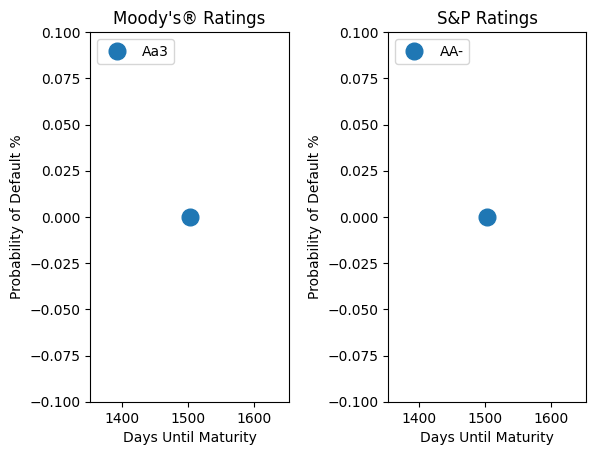

In [175]:
prob_default_term_structure(bond_df_result)

In [177]:
tgt_website = r"https://www.spglobal.com/ratings/en/research/articles/200429-default-transition-and-recovery-2019-annual-global-corporate-default-and-rating-transition-study-11444862"

In [178]:
def get_transition_matrix(tgt_website):
    df_list = pd.read_html(tgt_website)
    matrix_result_df = df_list[22]

    return matrix_result_df

transition_matrix_df = get_transition_matrix(tgt_website)


In [179]:
sp_clean_result_df = pd.DataFrame(transition_matrix_df.iloc[:34, :19].dropna(axis=0))
sp_clean_result_df

Average One-Year Transition Rates For Global Corporates By Rating Modifier (1981-2019) (%)  \
                                                                                      From/to   
0                                                 AAA                                           
2                                                 AA+                                           
4                                                  AA                                           
6                                                 AA-                                           
8                                                  A+                                           
10                                                  A                                           
12                                                 A-                                           
14                                               BBB+                                           
16                                                BBB                                           
18                                               BBB-                                           
20                                                BB+                                           
22                                                 BB                                           
24                                                BB-                                           
26                                                 B+                                           
28                                                  B                                           
30                                                 B-                                           
32                                              CCC/C                                           

                                                                          \
      AAA    AA+     AA    AA-     A+      A     A-   BBB+    BBB   BBB-   
0   87.03   5.89   2.51   0.69   0.16   0.24   0.13   0.00   0.05   0.00   
2    2.31  78.94  10.91   3.54   0.71   0.33   0.19   0.05   0.09   0.05   
4    0.42   1.31  80.76   8.53   2.72   1.15   0.36   0.39   0.13   0.08   
6    0.04   0.11   3.77  78.80   9.68   2.19   0.60   0.25   0.15   0.07   
8    0.00   0.06   0.44   4.44  78.38   8.73   2.15   0.61   0.34   0.09   
10   0.03   0.04   0.22   0.41   5.32  78.88   6.74   2.38   0.86   0.27   
12   0.04   0.01   0.06   0.15   0.42   6.49  78.12   7.23   1.98   0.57   
14   0.00   0.01   0.05   0.06   0.20   0.74   7.13  75.83   7.98   1.56   
16   0.01   0.01   0.04   0.03   0.10   0.31   1.00   7.73  76.00   6.11   
18   0.01   0.01   0.02   0.04   0.06   0.14   0.25   1.17   9.31  72.40   
20   0.04   0.00   0.00   0.03   0.03   0.08   0.08   0.41   1.59  11.33   
22   0.00   0.00   0.03   0.01   0.00   0.06   0.05   0.16   0.47   2.00   
24   0.00   0.00   0.00   0.01   0.01   0.01   0.05   0.09   0.23   0.35   
26   0.00   0.01   0.00   0.03   0.00   0.03   0.06   0.04   0.05   0.10   
28   0.00   0.00   0.01   0.01   0.00   0.03   0.04   0.02   0.05   0.03   
30   0.00   0.00   0.00   0.00   0.02   0.03   0.00   0.06   0.05   0.10   
32   0.00   0.00   0.00   0.00   0.03   0.00   0.08   0.05   0.08   0.05   

                                                            
      BB+     BB    BB-     B+      B     B-    CCC      D  
0    0.03   0.05   0.03   0.00   0.03   0.00   0.05   0.00  
2    0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00  
4    0.05   0.03   0.02   0.02   0.00   0.02   0.05   0.02  
6    0.03   0.00   0.00   0.03   0.08   0.00   0.00   0.03  
8    0.06   0.09   0.01   0.07   0.03   0.00   0.00   0.05  
10   0.10   0.10   0.06   0.08   0.02   0.00   0.01   0.05  
12   0.13   0.13   0.11   0.10   0.02   0.01   0.03   0.06  
14   0.36   0.29   0.13   0.15   0.10   0.02   0.06   0.10  
16   1.34   0.58   0.27   0.22   0.11   0.03   0.05   0.16  
18   5.47   2.08   0.83   0.36   0.22   0.1

In [180]:
# Will scrape the default probability for each rating

sp_rating_list = [
    "AAA",
    "AA+",
    "AA",
    "AA-",
    "A+",
    "A",
    "A-",
    "BBB+",
    "BBB",
    "BBB-",
    "BB+",
    "BB",
    "BB-",
    "B+",
    "B",
    "B-",
]

ccc_list = ["CCC+", "CCC", "CCC-", "CC+", "CC", "CC-", "C+", "C", "C-"]

sp_rating = None

for i in sp_rating_list:
    if bond_df_result["S&P"].iloc[0] == i:
        sp_rating = bond_df_result["S&P"].iloc[0]

if sp_rating is None:
    for i in ccc_list:
        if bond_df_result["S&P"].iloc[0] == i:
            sp_rating = "CCC/C"

sp_transition_dp = 0

for i in range(33):
    if transition_matrix_df.loc[i][0] == sp_rating:
        sp_transition_dp += float(sp_clean_result_df.loc[i][18])

sp_transition_dp

0.03

In [181]:
# Compare the nearest maturity Market-implied probability of default with
# the historical probability of default in the Standard & Poor's 2019 transition matrix
print(
    "Market-implied probability of default = %s"
    % (bond_df_result["Probability of Default %"].iloc[0])
    + "%"
)
print("Standard & Poor's probability of default = %s" % (sp_transition_dp) + "%")

Market-implied probability of default = 0.0%
Standard & Poor's probability of default = 0.03%
